# Time Series Study - https://reurl.cc/0oLzpx

- 過去動手做單元曾經出現過的所有資料都可以點擊[這個連結](https://reurl.cc/QdMz09)下載， 縮短網址如後： https://reurl.cc/QdMz09

# 載入常用套件及常數定義

In [1]:
try:
    from google.colab import drive, files
    in_colab = True
except ModuleNotFoundError:
    in_colab = False

if in_colab:
    home_dir = ''
    drive.mount('/content/drive')
    groot_dir = '/content/drive/My Drive/adventures/'
else:
    from pathlib import Path
    home_dir = str(Path.home())
    groot_dir = home_dir + '/Google Drive/adventures/'

import matplotlib as mpl
mpl.rc('axes', labelsize=10)
mpl.rc('xtick', labelsize=10)
mpl.rc('ytick', labelsize=10)
mpl.rc('font', size=12)

import datetime 
from dateutil.relativedelta import *
import matplotlib.pyplot as plt
import sklearn
assert sklearn.__version__ >= "0.20"
import seaborn as sns
import pandas as pd
import numpy as np
import math
import os
import sys
import gdown
import requests
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
from pandas.plotting import register_matplotlib_converters

figure_dir = groot_dir + 'figure/tiempo/'
data_dir = groot_dir + 'tiempo/'

gfigure = lambda name: figure_dir + name + '.png'
output_fig = lambda name: plt.savefig( gfigure(name), dpi = 100)

local_time = lambda x, offset: x + relativedelta(hours= offset)
def local_now(hours = 8):
    return datetime.datetime.now() + relativedelta(hours = hours if in_colab else 0)

def print_now():
    return print(local_now())

def print_local_now():
    return print('Local Time:', local_now())

def DropboxLink(did, fname):
    return 'https://dl.dropboxusercontent.com/s/%s/%s' % \
    (did, fname)

def fetch_gdrive_file(fid, local_save):
    remote_url = 'https://drive.google.com/uc?id=' + fid
    gdown.download(remote_url, local_save, quiet = False)

def fetch_file_via_requests(url, save_in_dir):
    local_filename = url.split('/')[-1]
    # NOTE the stream=True parameter below
    output_fpath = save_in_dir + local_filename
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(output_fpath, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
                    # f.flush()
    return output_fpath
        

def round_up(n, decimals=0):
    multiplier = 10 ** decimals
    return math.ceil(n * multiplier) / multiplier

def round_down(n, decimals=0):
    multiplier = 10 ** decimals
    return math.floor(n * multiplier) / multiplier
    
def start_plot(figsize=(10, 8), style = 'whitegrid', dpi = 100):
    fig = plt.figure(figsize=figsize, dpi=dpi)
    gs = fig.add_gridspec(1,1)
    plt.tight_layout()
    with sns.axes_style(style):
        ax = fig.add_subplot(gs[0,0])
    return ax

def start_plot_hires(figsize=(10, 8), style = 'whitegrid',
        dpi = 200):
    fig = plt.figure(figsize=figsize, dpi=dpi)
    gs = fig.add_gridspec(1,1)
    plt.tight_layout()
    with sns.axes_style(style):
        ax = fig.add_subplot(gs[0,0])
    return ax

JHU_CSSE = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/'

print('\nRunning on %s' % sys.platform)
print('Python Version', sys.version)
print('Data storage points to ==>', data_dir)

print('\nThis module is aimed to study time seires basics...') 
print('\nLibraries and dependenciess imported')
print_now()


Running on darwin
Python Version 3.8.5 (v3.8.5:580fbb018f, Jul 20 2020, 12:11:27) 
[Clang 6.0 (clang-600.0.57)]
Data storage points to ==> /Users/roger/Google Drive/adventures/tiempo/

This module is aimed to study time seires basics...

Libraries and dependenciess imported
2020-08-28 00:24:30.798139


## 時間序列常用套件

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from pandas.plotting import autocorrelation_plot, lag_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA, ARIMA
import statsmodels.api as sm

import pandas_datareader.data as web
import yfinance as yf

from pmdarima.arima import auto_arima

# 溫故知新

## 下載 Johns Hopkins University CSSE 所提供資料

In [2]:
selected_rows = lambda d, country: d[d['Country/Region'] == country].iloc[:,4:].sum()
cdata = lambda d, country: d[d['Country/Region'] == country].iloc[:,4:].sum().reset_index().rename(columns={'index':'date', 0:country})  
    
github = JHU_CSSE
jhudata = lambda x: csv_holder % x
csv_holder = 'time_series_covid19_%s_global.csv'

！ 依照疫情的發展狀況，Johns Hopkins 應該會繼續維護疫情資料，所以以下程式可以繼續下載。若是 JHU 更改格式或遷移放資料的地方，需要修改程式。我想到時大家都應該自己可以應付這種變化了。

In [3]:
#
# helper macros and constant definitions
#
selected_rows = lambda d, country: d[d['Country/Region'] == country].iloc[:,4:].sum()
github = JHU_CSSE
csv_holder = 'time_series_covid19_%s_global.csv'
csvlist = ['confirmed', 'deaths', 'recovered']
put_data_here = data_dir
jhudata = lambda x: csv_holder % x

print(f'data will be stored at {put_data_here:s}')

#
# 從 GitHub 下載資料，儲存在 put_data_here 目錄
#
for dfile in csvlist:
    url = github + csv_holder % dfile
    dled = fetch_file_via_requests(url, put_data_here)
    localname = dled.split('/')[-1]
    print(f'[ {localname:s} ] downloaded and saved')

#
# 從 Dropbox 下載 taiwan.csv
#
fetch_file_via_requests(
    DropboxLink('upr5klwy07bba3h', 'taiwan.csv'), data_dir
)

print('溫故知新： COVID19 data fetched from remote sites')
print_now()

data will be stored at /Users/roger/Google Drive/adventures/tiempo/
[ time_series_covid19_confirmed_global.csv ] downloaded and saved
[ time_series_covid19_deaths_global.csv ] downloaded and saved
[ time_series_covid19_recovered_global.csv ] downloaded and saved
溫故知新： COVID19 data fetched from remote sites
2020-08-28 00:24:42.384795


In [4]:
jhudata = lambda x: csv_holder % x
csv_holder = 'time_series_covid19_%s_global.csv'

csv_path = os.path.join(data_dir, 'taiwan.csv')
tdf = pd.read_csv(csv_path, 
    parse_dates = ['date'], index_col = ['date'])

peek = os.path.join(data_dir, jhudata('confirmed'))
peek_r = os.path.join(data_dir, jhudata('recovered'))
peek_d = os.path.join(data_dir, jhudata('deaths'))

df = pd.read_csv(peek)
recovered = pd.read_csv(peek)
deaths = pd.read_csv(peek_d)

df.loc[df['Country/Region'] == 'Taiwan*', 'Country/Region'] = 'Taiwan'
deaths.loc[deaths['Country/Region'] == 'Taiwan*', 'Country/Region'] = 'Taiwan'
recovered.loc[recovered['Country/Region'] == 'Taiwan*', 'Country/Region'] = 'Taiwan'
print('溫故知新： COVID19 data loaded and converted to Pandas DataFrame(s)')
print_now()

溫故知新： COVID19 data loaded and converted to Pandas DataFrame(s)
2020-08-28 00:24:43.518247


## JHU CSSE

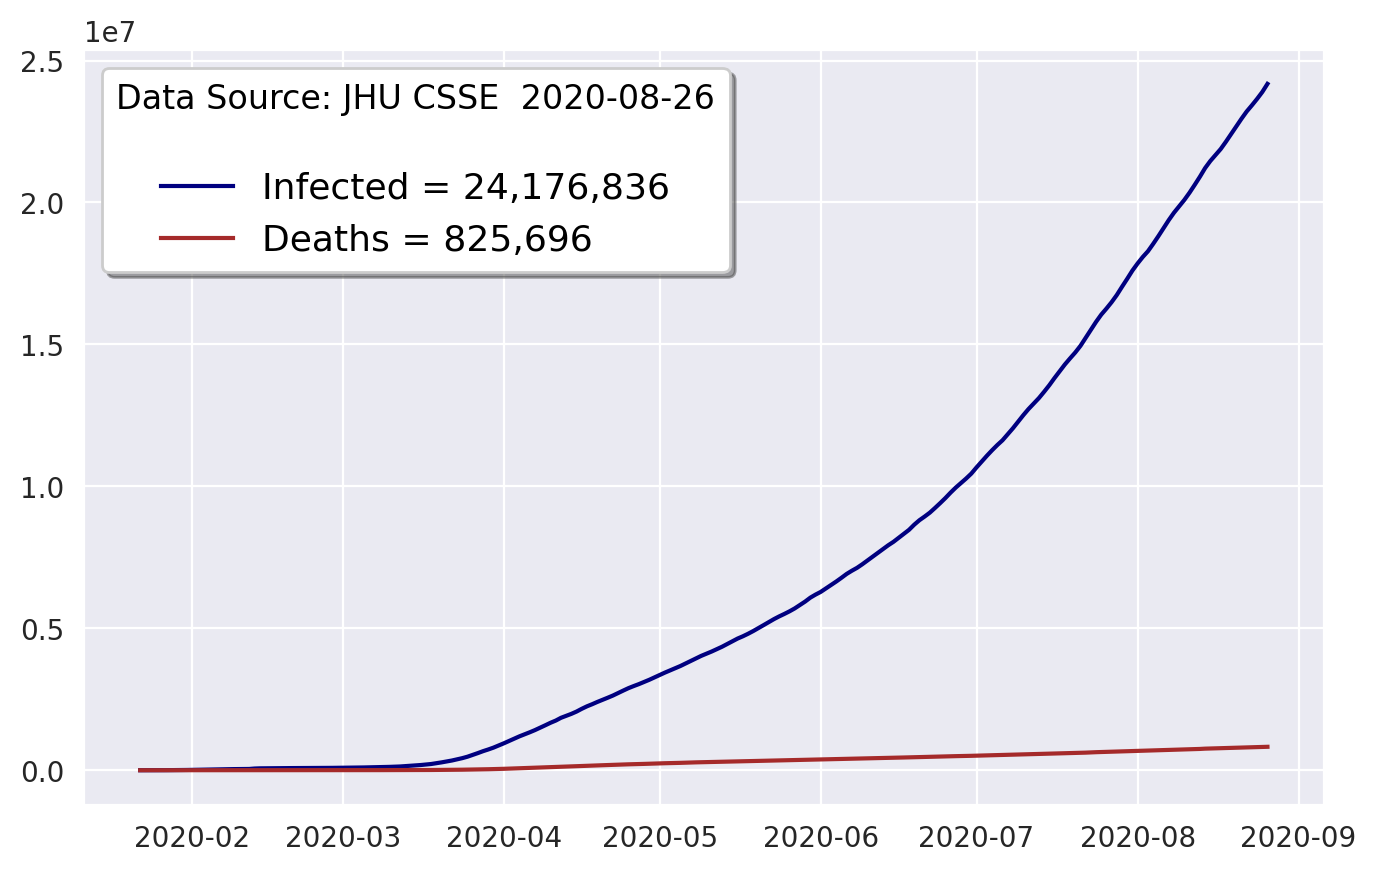

In [5]:
wdf = pd.DataFrame(data = df.iloc[:, 4:].sum(), 
    index = pd.DatetimeIndex(df.columns[4:]),
    columns = ['Worldwide'])
wdf['Deaths'] = deaths.iloc[:, 4:].sum()

ax = start_plot_hires(style='darkgrid', figsize=(8, 5))
ax.plot(wdf.Worldwide, c = 'navy',
    label = 'Infected = {:,d}'.format(wdf.Worldwide[-1]))
ax.plot(wdf.Deaths, c = 'brown',
    label = 'Deaths = {:,d}'.format(wdf.Deaths[-1]))
ax.legend( title = 'Data Source: JHU CSSE  %s\n' % \
    str(wdf.index[-1]).split(' ')[0], title_fontsize = 12,
    shadow=True, fancybox=True, fontsize=13)
output_fig('worldwide')

<AxesSubplot:>

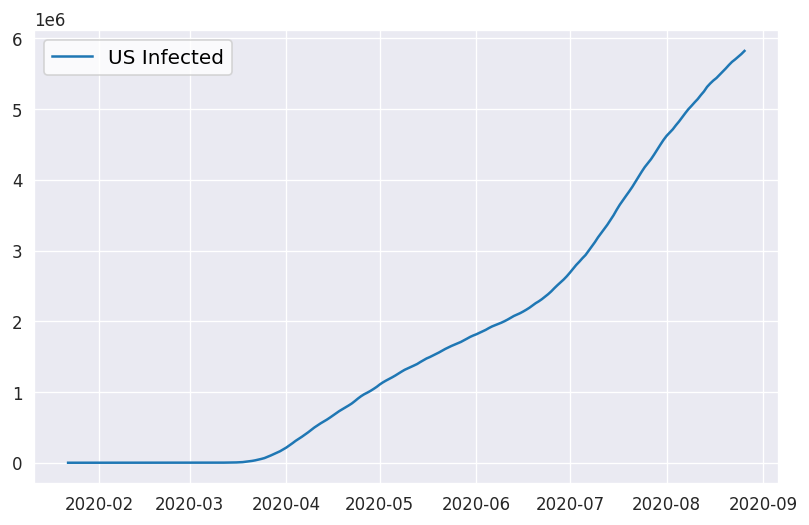

In [6]:
country = 'US'
data = selected_rows(df, country)
ud = pd.DataFrame(data = data.values, 
    index = pd.DatetimeIndex(data.index) , 
    columns = ['%s Infected' % country])
ax = start_plot(figsize=(8, 5),dpi=120, style='darkgrid')
sns.lineplot(data=ud, ax = ax)

<AxesSubplot:xlabel='date'>

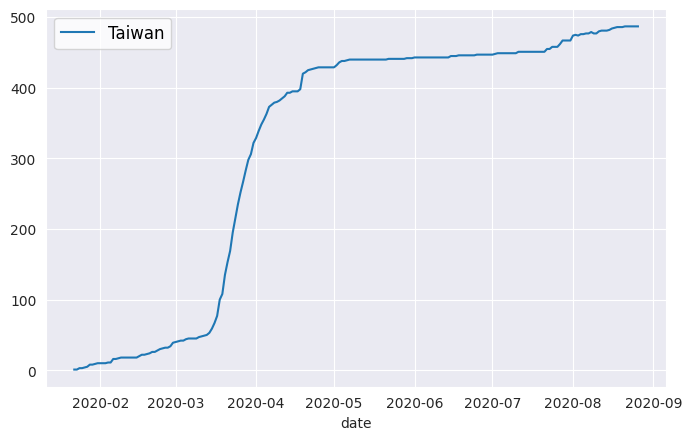

In [7]:
udf = cdata(df, 'Taiwan')
udf.date = pd.to_datetime(udf.date)
udf.set_index(['date'], drop=True, inplace=True)
ax = start_plot(figsize=(8, 5),dpi=100, style='darkgrid')
sns.lineplot(data=udf, ax = ax)

## taiwan.csv

- [疫情數據全報導](https://udn.com/news/COVID19)：此報導會每日更新網頁內容

根據 2020-08-01 記者會公佈資料：

> 指揮中心統計，國內截至目前累計81,826例(含80,728例排除)，其中474例確診，分別為382例境外移入，55例本土病例、36例敦睦艦隊及**<u>1例待釐清</u>**。

因此自8月1日起，taiwan.csv 資料增加一個欄位 tbd (to_be_decided)，更名為 taiwan_aug.csv，此一 **<u>公開版本</u>**會維護到 2020-08-10。


In [ ]:
fetch_file_via_requests(
    DropboxLink('upr5klwy07bba3h', 'taiwan.csv'), data_dir )

fetch_file_via_requests(
    DropboxLink('sfxv53gspz8w6mv', 'taiwan_aug.csv'), data_dir )

'/Users/roger/Google Drive/adventures/tiempo/taiwan_aug.csv'

In [8]:
fetch_file_via_requests(
    DropboxLink('sfxv53gspz8w6mv', 'taiwan_aug.csv'), 
    data_dir )

'/Users/roger/Google Drive/adventures/tiempo/taiwan_aug.csv'

In [9]:
csv_path = os.path.join(data_dir, 'taiwan.csv')
tdf = pd.read_csv(csv_path, 
    parse_dates = ['date'], index_col = ['date'])
tdf.tail()

,Taiwan,Local,Imported,Deaths,Recovered,Panshi
date,,,,,,
2020-07-27,462,55,371,7,440,36
2020-07-28,467,55,376,7,440,36
2020-07-29,467,55,376,7,440,36
2020-07-30,467,55,376,7,440,36
2020-07-31,467,55,376,7,440,36


In [10]:
csv_aug = os.path.join(data_dir, 'taiwan_aug.csv')
tdf_aug = pd.read_csv(csv_aug, 
    parse_dates = ['date'], index_col = ['date'])
tdf_aug.tail()

,Taiwan,Local,Imported,Deaths,Recovered,Panshi,tbd
date,,,,,,,
2020-08-23,487,55,395,7,457,36,1
2020-08-24,487,55,395,7,457,36,1
2020-08-25,487,55,395,7,457,36,1
2020-08-26,487,55,395,7,457,36,1
2020-08-27,487,55,395,7,457,36,1


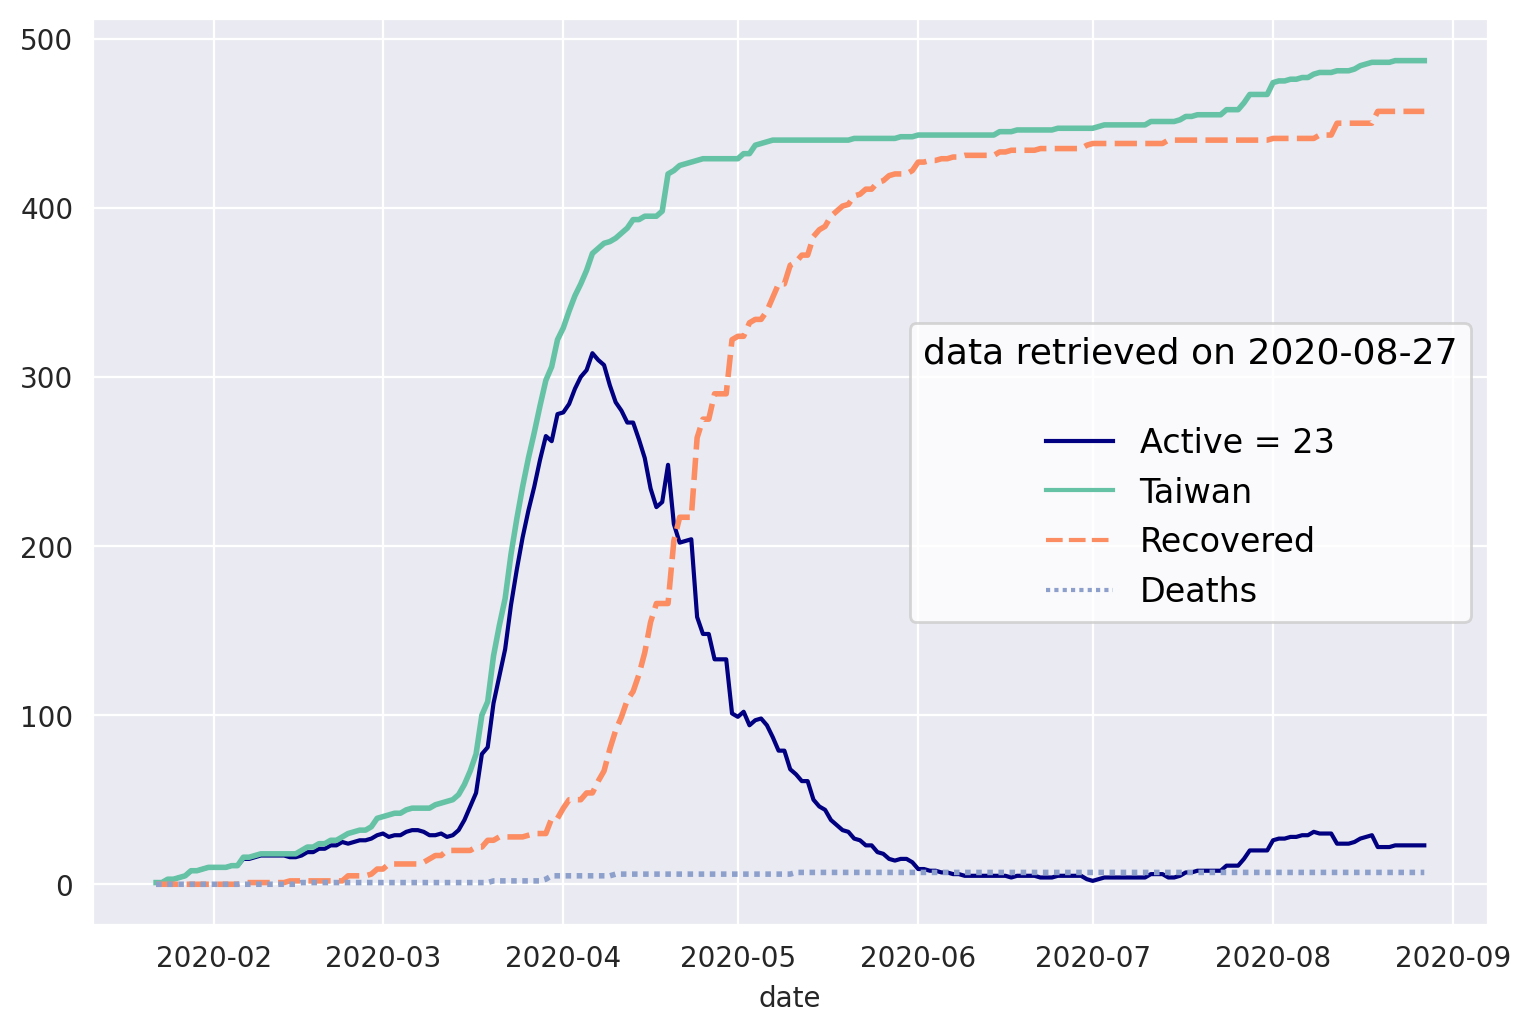

In [11]:
ax = start_plot_hires(style='darkgrid', figsize=(9, 6))
tdf2 = tdf_aug[['Taiwan', 'Recovered', 'Deaths']]

ax.plot(tdf2.Taiwan - tdf2.Recovered - tdf2.Deaths, 
    c = 'navy', label = 'Active = %d' % \
    (tdf2.Taiwan[-1] - tdf2.Recovered[-1] - tdf2.Deaths[-1]))
sns.lineplot(data = tdf2, palette = 'Set2', lw = 2)
ax.legend(title = 'data retrieved on %s\n' % \
    str(tdf2.index[-1]).split(' ')[0], title_fontsize = 13)

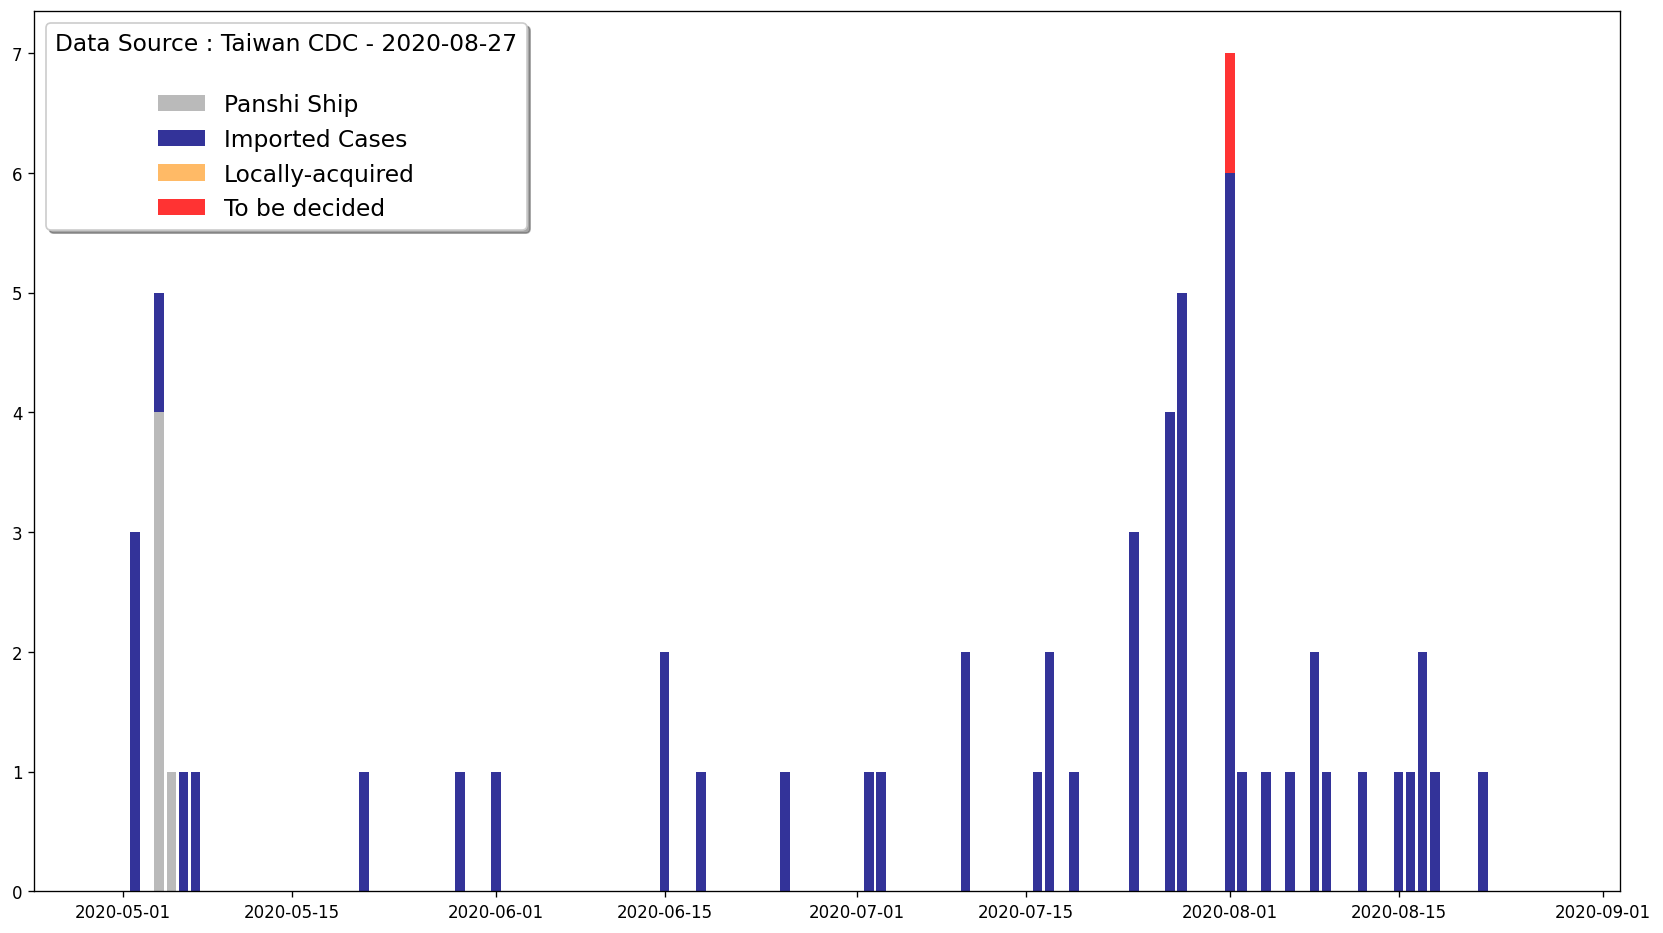

In [12]:
zdf = pd.DataFrame()
zdf['Taiwan'] = tdf_aug.Taiwan.diff(1)
zdf['Local'] = tdf_aug.Local.diff(1)
zdf['Imported'] = tdf_aug.Imported.diff(1)
zdf['Panshi'] = tdf_aug.Panshi.diff(1)
zdf['tbd'] = tdf_aug.tbd.diff(1)
zdf= zdf[1:]

zdf = zdf[-120:]

fig,ax = plt.subplots(figsize=(14,8), dpi = 120)
plt.tight_layout()
ax.bar(zdf.index, zdf.Panshi, color = 'darkgray', alpha = 0.8, label = 'Panshi Ship')
ax.bar(zdf.index, zdf.Imported, color = 'navy', alpha = 0.8,
       bottom = zdf.Panshi, label = 'Imported Cases')
ax.bar(zdf.index, zdf.Local, color = 'darkorange', alpha = 0.6, 
       label = "Locally-acquired",
       bottom = zdf.Panshi + zdf.Imported)
ax.bar(zdf.index, zdf.tbd, color = 'red', alpha = 0.8, 
       label = "To be decided",
       bottom = zdf.Panshi + zdf.Imported + zdf.Local)
ax.legend( title = 'Data Source : Taiwan CDC - %s\n' % str(zdf.index[-1]).split(' ')[0], 
    title_fontsize = 14,
    loc = 'upper left', frameon = True, shadow = True, fontsize = 14)

# 時間序列範例

 [Air Line Passengers from 1949 to 1960](https://www.kaggle.com/chirag19/air-passengers) & [Daily Minimum Temperature in Melbouren](https://www.kaggle.com/paulbrabban/daily-minimum-temperatures-in-melbourne)，是從 Kaggle 平台收集的。
 
Amtrak Data 是一本教科書的範例資料，其他資料，則是由 [ritvikmath](http://ritvikmath.com/) 網站提供的。

In [ ]:
fetch_file_via_requests(
    DropboxLink('udj6cygjgoi6upi','AirPassengers.csv' ), 
    data_dir)

fetch_file_via_requests(
    DropboxLink('lqt5rplifpc1h1f', 
    'daily-minimum-temperatures-in-me.csv'), data_dir )

fetch_file_via_requests(
    DropboxLink('epv47nzdegkhcay', 
    'Amtrak data.csv'), data_dir )

fetch_file_via_requests(
    DropboxLink('lemgwxxl1simbwi','ice_cream.csv' ), 
    data_dir)

fetch_file_via_requests(
    DropboxLink('z78zc2y6q8by5f1','catfish.csv' ), 
    data_dir)

## AirPassengers

In [ ]:
import statsmodels.api as sm
def simple_ols(xvec, yvec):
    Xadd = sm.add_constant(xvec) # adding a constant
    model = sm.OLS(yvec, Xadd).fit()   
    return model

## temperature

In [ ]:
temp_csv = os.path.join(data_dir, 'daily-min-temperatures.csv')
melbourne = pd.read_csv( temp_csv, header = 0,
    index_col = ['Date'], parse_dates=['Date'])

## ice cream

In [ ]:
filepath = os.path.join(data_dir, 'ice_cream.csv')
ice = pd.read_csv(filepath, index_col = 0, 
    parse_dates=['DATE'])
ice.rename(columns={'IPN31152N':'production'}, inplace=True)
ice.head()


,production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


## Amtrak

In [ ]:
filepath = os.path.join(data_dir, 'Amtrak data.csv')
data = pd.read_csv(filepath)
data = data.dropna()
data

,Month,Ridership
0,Jan-91,1708.917
1,Feb-91,1620.586
2,Mar-91,1972.715
3,Apr-91,1811.665
4,May-91,1974.964
...,...,...
154,3-Nov,2076.054
155,3-Dec,2140.677
156,4-Jan,1831.508
157,4-Feb,1838.006


### Method 1

### Method 2

# 盡信書不如無書

- [The Lahman Baseball Database](http://www.seanlahman.com/baseball-archive/statistics/) & [Documentation](http://www.seanlahman.com/files/database/readme2017.txt)

- [Baseball data analytics fun](https://medium.com/@stuart.zussman/baseball-data-analytics-fun-554137b7f101)
- [維基百科：棒球數據](https://zh.wikipedia.org/wiki/%E6%A3%92%E7%90%83%E7%B5%B1%E8%A8%88#%E6%89%93%E6%93%8A%E6%95%B8%E6%93%9A)
- [打擊數據篇](https://terryex.pixnet.net/blog/post/36215363#:~:text=%E3%80%8C%E6%89%93%E6%95%B8%E3%80%8D%E7%9A%84%E6%AD%A3%E5%BC%8F%E5%90%8D%E7%A8%B1,%E6%93%8A%E6%88%96%E6%98%AF%E5%A6%A8%E7%A4%99%E6%89%93%E6%93%8A%E3%80%82)
------
- playerID       Player ID code
- yearID         Year
- stint          player's stint (order of appearances within a season)
- teamID         Team
- lgID           League
- G              Games
- AB             At Bats
- R              Runs
- H              Hits
- 2B             Doubles
- 3B             Triples
- HR             Homeruns
- RBI            Runs Batted In
- SB             Stolen Bases
- CS             Caught Stealing
- BB             Base on Balls
- SO             Strikeouts
- IBB            Intentional walks
- HBP            Hit by pitch
- SH             Sacrifice hits
- SF             Sacrifice flies
- GIDP           Grounded into double plays

In [ ]:
fetch_file_via_requests(
    DropboxLink('hhl3b3ddsqc6nmf', 'Teams.csv'), data_dir )

In [ ]:
stat_csv = os.path.join(data_dir, 'Teams.csv')
mlb = pd.read_csv(stat_csv)
mlb.head()

,yearID,lgID,teamID,franchID,divID,Rank,G,Ghome,W,L,...,DP,FP,name,park,attendance,BPF,PPF,teamIDBR,teamIDlahman45,teamIDretro
0,1871,NaN,BS1,BNA,NaN,3,31,NaN,20,10,...,24,0.834,Boston Red Stockings,South End Grounds I,NaN,103,98,BOS,BS1,BS1
1,1871,NaN,CH1,CNA,NaN,2,28,NaN,19,9,...,16,0.829,Chicago White Stockings,Union Base-Ball Grounds,NaN,104,102,CHI,CH1,CH1
2,1871,NaN,CL1,CFC,NaN,8,29,NaN,10,19,...,15,0.818,Cleveland Forest Citys,National Association Grounds,NaN,96,100,CLE,CL1,CL1
3,1871,NaN,FW1,KEK,NaN,7,19,NaN,7,12,...,8,0.803,Fort Wayne Kekiongas,Hamilton Field,NaN,101,107,KEK,FW1,FW1
4,1871,NaN,NY2,NNA,NaN,5,33,NaN,16,17,...,14,0.840,New York Mutuals,Union Grounds (Brooklyn),NaN,90,88,NYU,NY2,NY2


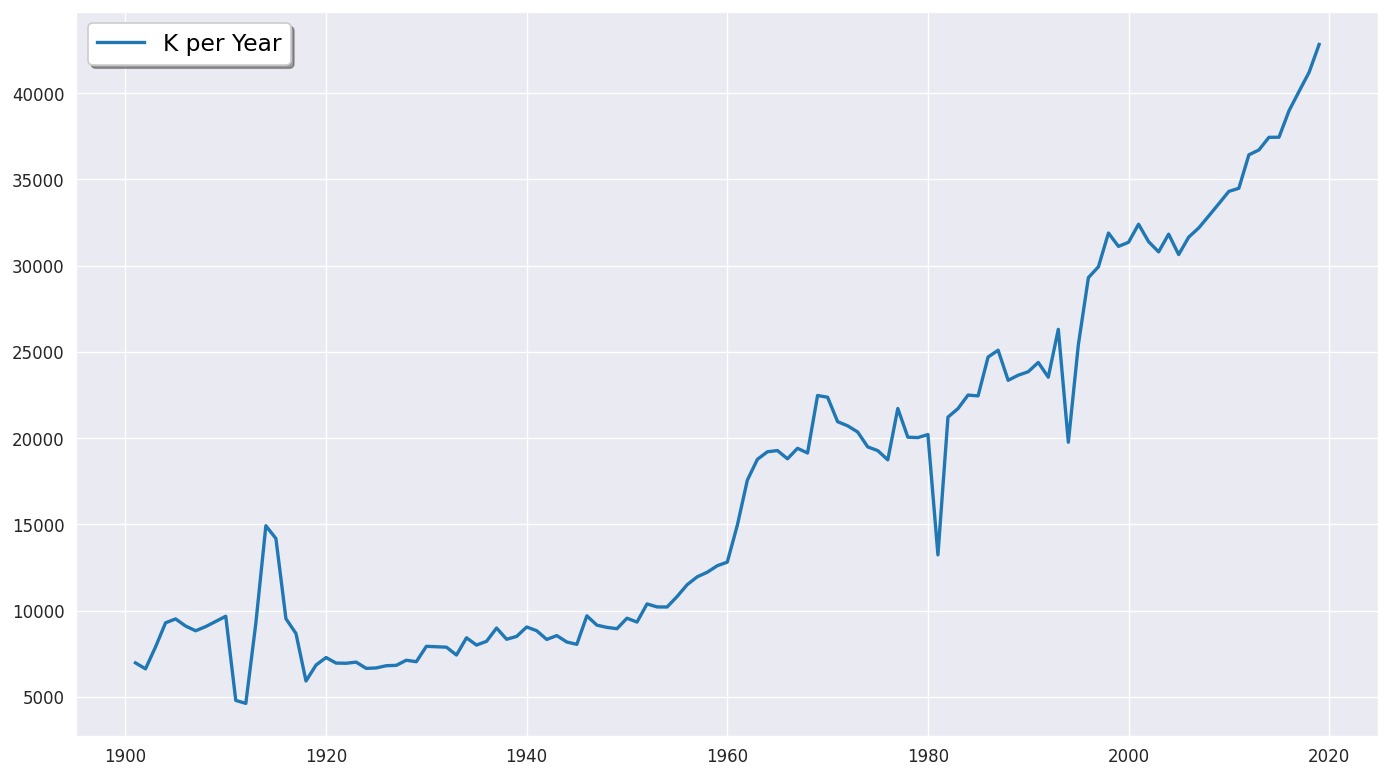

In [ ]:
ax = start_plot(style='darkgrid', figsize=(14, 8), dpi = 120)
ax.plot(so, label = 'K per Year', lw = 2)
so = mlb.groupby('yearID').sum()['SO']
hits = mlb.groupby('yearID').sum()['H']
ax.legend(shadow=True, fontsize = 14, loc = 'upper left')

# 如何分解時間序列

以下用 statsmodels 的 [seasonal_decompose](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) 拆解時間序列元件，細節需參閱[例1](https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/)以及[例2](https://gist.github.com/balzer82/5cec6ad7adc1b550e7ee)， 例1的推薦的方法簡單，但是不好控制輸出的格式和品質，例2提供更多彈性以及更好的輸出品質。


```
推薦：以四個 ax object，分別處理 df， trend，seanonality, residuals，.plot() 四個子圖：

# te is the time-indexed dataframe 
res = seasonal_decompose(te, model = 'additive', period = 360)

fig, ax  = plt.subplots( 4, 1, figsize = (16, 10), sharex = True)

# plot the original data set, can be viewed as "observation" 
# subplot shown in origianl output
te.plot(ax = ax[0])

# trend part
res.trend.plot(ax=ax[1])
ax[1].legend(['Trend'])

# seasonal part
res.seasonal.plot(ax=ax[2])
ax[2].legend(['Seasonal'], loc = 'best')

#residuals part
res.resid.plot(ax=ax[3])
ax[3].legend(['Residuals'], loc = 'best')
ax[3].set_xlabel('whatever you want')
```

也可以使用 subplots(1, 1, figsize=(hsize, vsize)) 方式，只呈現四個子圖中其中一個，所以此法彈性較高。

# 用美股資料練習 Smoothing

載入美股資料，最常用的兩個套件是 pandas_datareader & yfiance，使用前記得確認這兩個套件已經安裝好

```
!pip3 install yfinance
!pip3 install pandas_datareader
```
- [pandas_datareader](https://pandas-datareader.readthedocs.io/en/latest/index.html)
- [yfinance](https://pypi.org/project/yfinance/)

##  pandas_datareader
[pandas_datareader](https://pandas-datareader.readthedocs.io/en/latest/)使用 python 標準函式庫的 [datetime](https://docs.python.org/3/library/datetime.html) class 指定起訖時間。範例如下：
```
import pandas_datareader.data as web
import datetime as dt
start = dt.datetime(2017,1,1)
end = dt.datetime.now() 
df = web.DataReader('GOOG', 'yahoo', start, end)
```

DataReader 下載的資料格式是 Pandas Dataframe, 的欄位包括 'High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close' 以及 Datetime 格式的索引 ‘Date'。

### yfinance

## Exponentially weighted windows

- [Exponentially weighted windows](https://pandas.pydata.org/pandas-docs/stable/user_guide/computation.html#stats-moments-exponentially-weighted)
- [pandas.DataFrame.ewm](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html)

- 用 [statsmodels](https://www.statsmodels.org/dev/examples/notebooks/generated/exponential_smoothing.html) 執行 [simple exponential smoothing](https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.SimpleExpSmoothing.html)

- [Averaging and smoothing models](https://people.duke.edu/~rnau/411avg.htm)
- [Exponential Smoothing: Definition of Simple, Double and Triple](https://www.statisticshowto.datasciencecentral.com/exponential-smoothing/)
- [How to Build Exponential Smoothing Models Using Python](https://medium.com/datadriveninvestor/how-to-build-exponential-smoothing-models-using-python-simple-exponential-smoothing-holt-and-da371189e1a1)
- [7.1 Simple exponential smoothing](https://otexts.com/fpp2/ses.html)


# ADF-Test

- [Augmented Dickey-Fuller Test in Python](https://www.hackdeploy.com/augmented-dickey-fuller-test-in-python/)

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

class StationarityTests:
    
    def __init__(self, significance=.05):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None
        
    def ADF_Stationarity_Test(self, timeseries, printResults = True):

        #Dickey-Fuller test:
        adfTest = adfuller(timeseries, autolag='AIC')
        
        self.pValue = adfTest[1]
        
        if (self.pValue<self.SignificanceLevel):
            self.isStationary = True
        else:
            self.isStationary = False
        
        if printResults:
            dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])

            #Add Critical Values
            for key,value in adfTest[4].items():
                dfResults['Critical Value (%s)'%key] = value

            print('Augmented Dickey-Fuller Test Results:')
            print(dfResults)

In [ ]:
air = pd.read_csv(os.path.join(data_dir, 'AirPassengers.csv'),
    index_col = 0, parse_dates = ['Month'])


In [ ]:
filepath = os.path.join(data_dir, 'ice_cream.csv')
ice = pd.read_csv(filepath, index_col = 0, 
    parse_dates=['DATE'])
ice.rename(columns={'IPN31152N':'production'}, inplace=True)

# Lag Plot

# Plot ACF and PACF

pandas 和 statsmodels 都能夠畫 ACF 和 PACF，而且這兩個模組畫 ACF 的方式很簡單，只要輸入簡單的一維 X 陣列

參考資料：

- Pandas [autocorrelation_plot](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.plotting.autocorrelation_plot.html?highlight=autocorrelation#pandas.plotting.autocorrelation_plot)
- statsmoels [plot_acf](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html) & [plot_pacf](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html?highlight=plot_pacf#statsmodels.graphics.tsaplots.plot_pacf)
- [Time Series Analysis Tutorial with Python](https://www.datacamp.com/community/tutorials/time-series-analysis-tutorial?utm_source=adwords_ppc&utm_campaignid=1455363063&utm_adgroupid=65083631748&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=1t1&utm_creative=332602034358&utm_targetid=aud-299261629574:dsa-473406571155&utm_loc_interest_ms=&utm_loc_physical_ms=21102&gclid=Cj0KCQiAyp7yBRCwARIsABfQsnSWrJdJVL935s4VtsqZnGIbgTJavvEo2jSdxtQeBUf57bkyj7X4PjYaArQBEALw_wcB)
- [Pandas Plotting Guide](https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html)

# AR, MA, ARMA 範例


以下幾個資料檔案都是由 YouTube Channel  [ritvikmath](http://ritvikmath.com/) 的[時間序列](https://www.youtube.com/watch?v=DeORzP0go5I&list=PLvcbYUQ5t0UHOLnBzl46_Q6QKtFgfMGc3)教學例子中取出，重新製作，以下幾個例子供大家參考。

## AR Model

In [ ]:
filepath = os.path.join(data_dir, 'ice_cream.csv')
df = pd.read_csv(filepath, index_col = 0, parse_dates=['DATE'])
df.rename(columns={'IPN31152N':'production'}, inplace=True)
df.head()

,production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


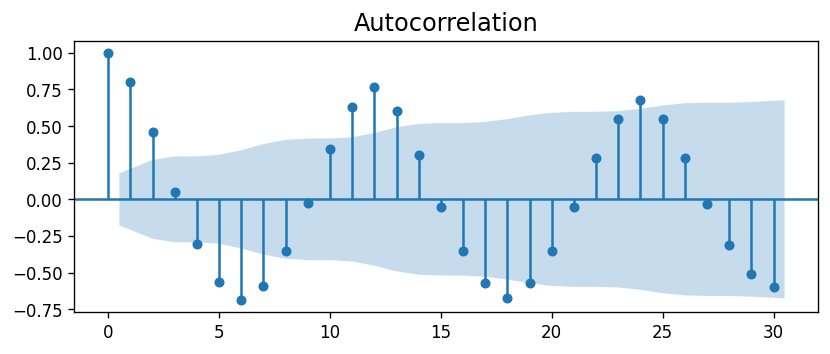

In [ ]:
# from pandas.plotting import plot_acf
df21 = df['2010-01-01':]
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig,ax = plt.subplots(figsize=(8, 3), dpi = 120)
plot_acf(df21.values.squeeze(), lags = 30, ax = ax)
plt.show()

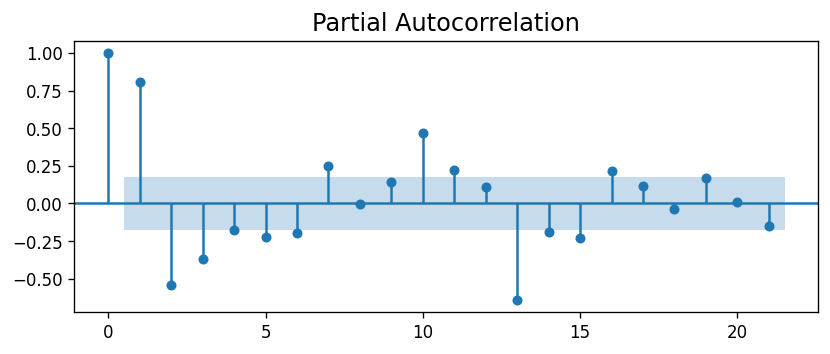

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig,ax = plt.subplots(figsize=(8, 3), dpi = 120)
plot_pacf(df21, ax = ax)
plt.show()

In [ ]:
from statsmodels.tsa.arima_model import ARMA

train_df = df21[:'2018-12-01']
test_df = df21['2019-01-01':'2019-12-01']

In [ ]:
%%time
model = ARMA(train_df, order=(3,0))
model = model.fit()
print(model.summary())

                              ARMA Model Results                              
Dep. Variable:             production   No. Observations:                  108
Model:                     ARMA(3, 0)   Log Likelihood                -374.085
Method:                       css-mle   S.D. of innovations              7.642
Date:                Fri, 31 Jul 2020   AIC                            758.170
Time:                        14:15:32   BIC                            771.580
Sample:                    01-01-2010   HQIC                           763.607
                         - 12-01-2018                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              103.5743      1.809     57.265      0.000     100.029     107.119
ar.L1.production     1.0469      0.088     11.960      0.000       0.875       1.218
ar.L2.production    -0.0523 

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [ ]:
y_pred = model.predict(start='2019-01-01', end = '2019-12-01')

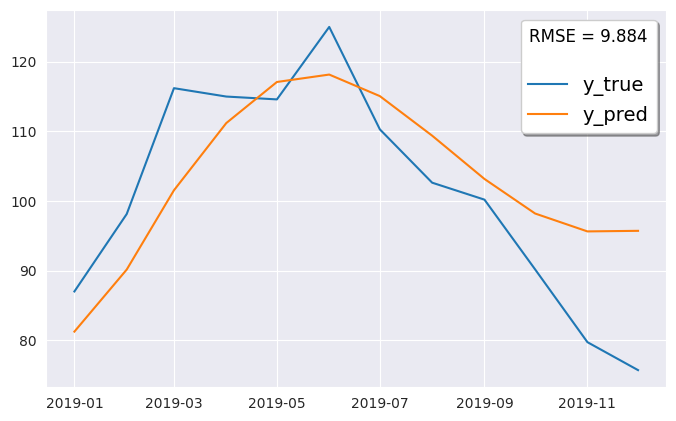

In [ ]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test_df.production, y_pred)
rmse = np.sqrt(mse)
ax = start_plot(figsize=(8,5), style='darkgrid')
ax.plot(test_df.production, label = 'y_true')
ax.plot(y_pred, label = 'y_pred')
ax.legend( title = 'RMSE = %.3f\n' %rmse,
    shadow=True,fontsize=14,loc='best')

## MA Model

$y_t = 50+0.4\times \epsilon_{t-1} + 0. 3\times \epsilon_{t-2} + \epsilon_t$

$\epsilon_t \sim [0,1]$

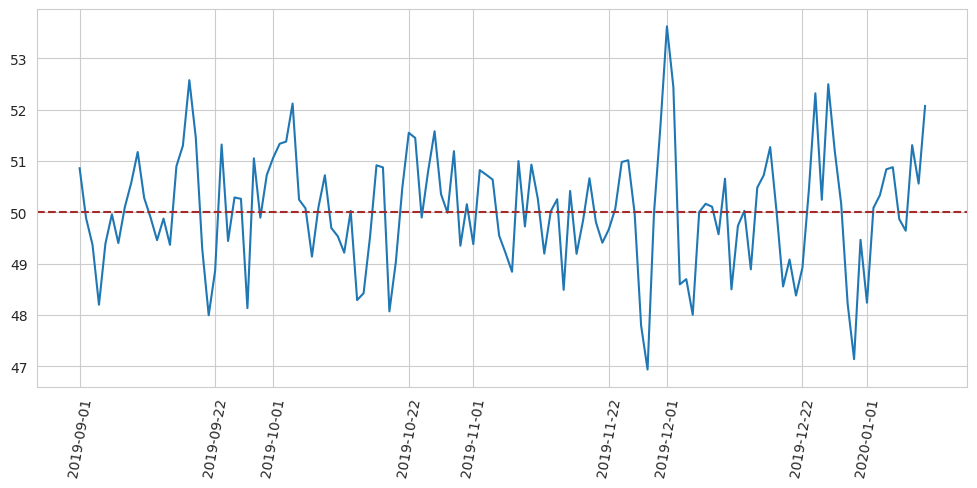

In [ ]:
errors = np.random.normal(0, 1, 400)
start_date, end_date ='2019-9-1', '2020-1-10'
date_index = pd.date_range(start=start_date, end=end_date)
mu = 50
series = []
for t in range(1,len(date_index)+1):
    series.append(mu + 0.4*errors[t-1] + 0.3*errors[t-2] + errors[t])

ax = start_plot(figsize=(12, 5))
ax.plot(date_index, series)
ax.axhline(y = mu, c = 'brown', ls = '--') 
ax.tick_params(axis='x', rotation = 80)

# Amtrak Prediction


投影片裏面的參考連結：

- https://stats.stackexchange.com/questions/281666/how-does-acf-pacf-identify-the-order-of-ma-and-ar-terms
- https://otexts.com/fpp2/non-seasonal-arima.html
- https://people.duke.edu/~rnau/411arim3.htm

In [ ]:
filepath = os.path.join(data_dir, 'Amtrak data.csv')
data = pd.read_csv(filepath)
data = data.dropna()
date_rng = pd.date_range(start='1991-1-1', end='2004-4-1', freq='M')
amt = pd.DataFrame(index = date_rng, data = data.Ridership.values, 
    columns = ['Ridership'])

## Decomposing Amtrak

## Lag

## Polynomial Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline, make_pipeline

def PolynomialRegression(X, y, deg = 3 ):

    the_model = make_pipeline(PolynomialFeatures(deg), 
        LinearRegression())

    the_model.fit(X, y)
    # if xdomain is None:
    #     xdomain = np.linspace( min(X.flatten()), max(X.flatten()), 00 ).reshape(-1, 1)
    fittedvalues = the_model.predict(X)
    return the_model, fittedvalues, r2_score(y, the_model.predict(X))


## ACF and PACF

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from pandas.plotting import autocorrelation_plot, lag_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### Lag-1, AR-6

### Lag(12, 1), ARIMA(12, 0, 3)

- (3,0,4)
- (4,0,1) 
- (12,0,3)

### Auto-Arima

In [ ]:
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA

model_autoARIMA = auto_arima(edf.Ridership, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=12, max_q=12, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_autoARIMA.summary())

# Storefornt Sales Prediction

In [ ]:
fetch_file_via_requests(
    DropboxLink('llhpyhb5vk5yv6v','test_store_17_final.csv' ), 
    data_dir)

fetch_file_via_requests(
    DropboxLink('oi1m5sqo78uej2m','train_store_17_final.csv' ), 
    data_dir)

訓練資料集的時間範圍是 **2008-2-8 到 2012-1-27**，測試資料集的時間範圍是 **2012-2-3 到 2012-10-26**

In [ ]:
training_file = 'train_store_17_final.csv'
test_file = 'test_store_17_final.csv'
csv_training = os.path.join(data_dir, 'train_store_17_final.csv')
csv_test = os.path.join(data_dir, 'test_store_17_final.csv')


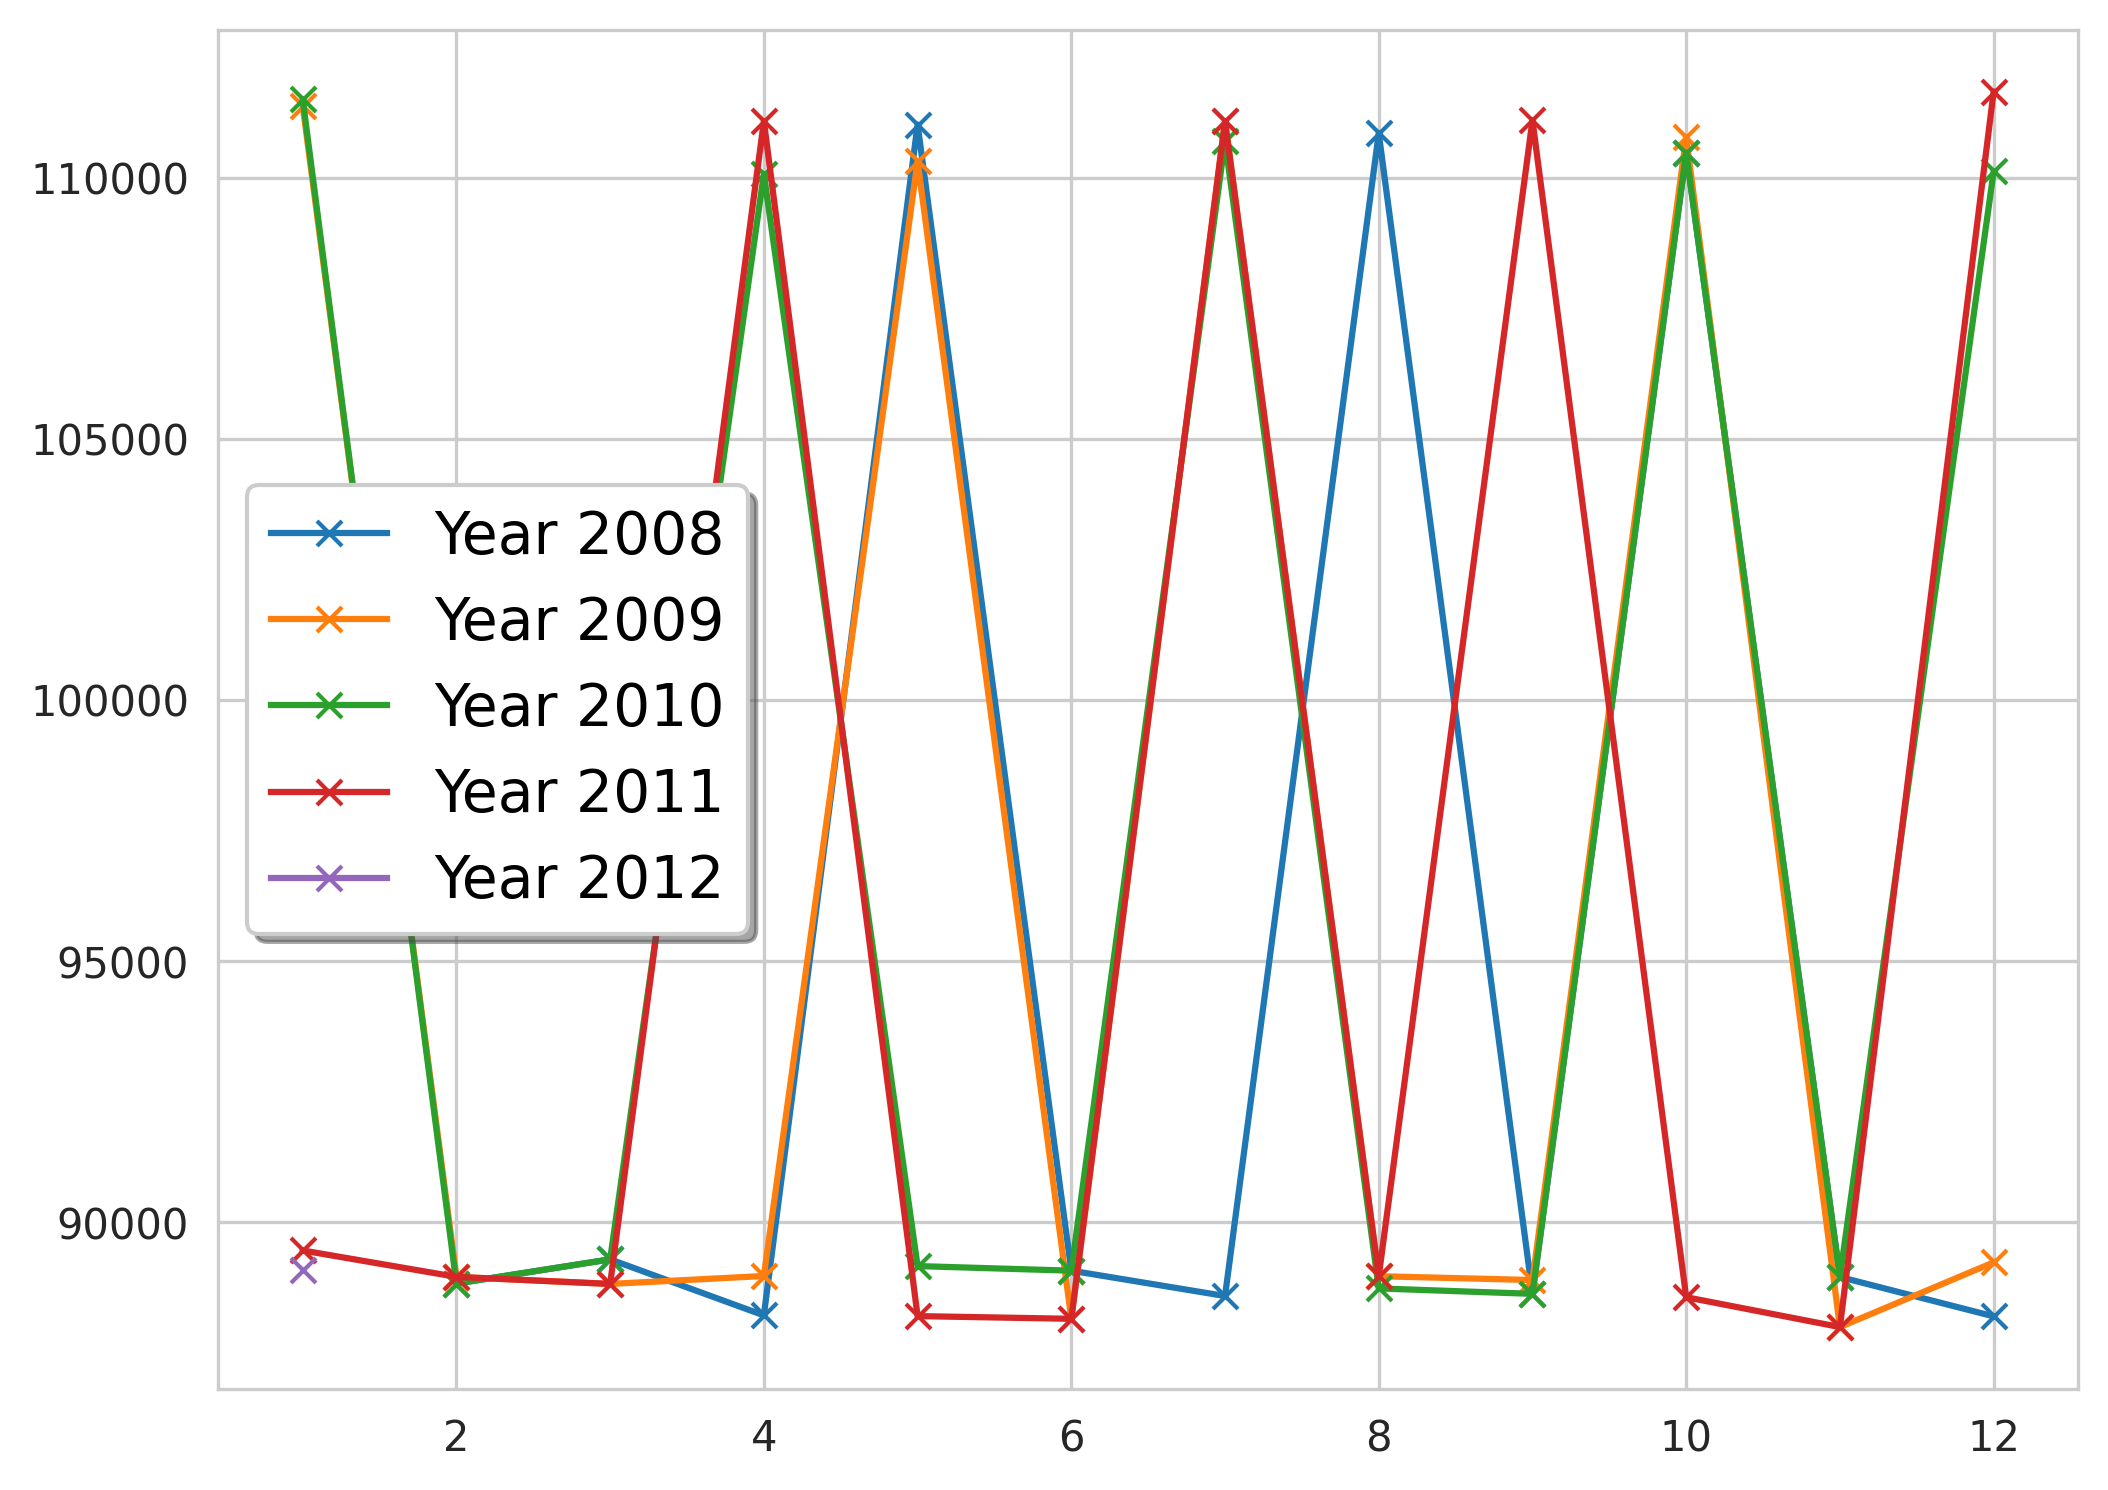

In [ ]:
a = df.groupby([df.index.year, df.index.month]).sum()['Weekly_Sales']
ax = start_plot(figsize=(8,6), dpi = 300)
for y in range(2008, 2013):
    b = a[y].reset_index()
    ax.plot(b.Date, b.Weekly_Sales, marker='x', 
            label = 'Year %d' % y)
ax.legend(shadow=True, fontsize=14)


## Here we go

In [ ]:
training_file = 'train_store_17_final.csv'
test_file = 'test_store_17_final.csv'
csv_training = os.path.join(data_dir, 'train_store_17_final.csv')
csv_test = os.path.join(data_dir, 'test_store_17_final.csv')
df1 = pd.read_csv(csv_training, parse_dates = ['Date'] , index_col = 'Date')
df2 = pd.read_csv(csv_test, parse_dates = ['Date'] , index_col = 'Date')

df = df1.append(df2)

split_points = len(df1)
df = df.drop(['Campaign2', 'Campaign3', 'Campaign4','Campaign5'], axis = 1)
df.IsHoliday = df.IsHoliday.map({False: 0, True:1})
# df.shape, df1.shape, df2.shape
train_df = df[:split_points]
test_df = df[split_points:]

y0 = df.Weekly_Sales
X0 = df.drop(['Weekly_Sales'], axis = 1)
train_y, test_y = y0[:split_points], y0[split_points:]

# End of File ☹